# deepctr

In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath('..'))
# ---------------------------------
from time import sleep
import numpy as np
import pandas as pd
import scipy
import tqdm
from copy import deepcopy
import tensorflow as tf
from tensorflow.keras.layers import Activation
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

from hyperopt import hp
from deepctr.models import xDeepFM
from deepctr.inputs import  SparseFeat, DenseFeat, get_feature_names
# ---------------------------------
from tools import CV, Tuning, CVGetScore, IdxValEncoder, LE, CyclicLR, MaxLrFinder
# ---------------------------------
from tools import focal_loss, gelu, mish
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({'focal_loss': focal_loss()})
get_custom_objects().update({'mish': mish})
get_custom_objects().update({'gelu': gelu})

In [2]:
train_df = pd.read_csv('../data/train.csv', index_col='id')
test_df = pd.read_csv('../data/test.csv', index_col='id')

# ord_5
for i in range(2):
    train_df[f'ord_5_{i}'] = train_df['ord_5'].str[i]
    test_df[f'ord_5_{i}'] = test_df['ord_5'].str[i]

# null
train_df['null'] = train_df.isna().sum(axis=1)
test_df['null'] = test_df.isna().sum(axis=1)

for col in test_df.columns:
    train_df[col].fillna('isnull', inplace=True)
    test_df[col].fillna('isnull', inplace=True)

# target
target = train_df['target']
y_train = target.values

# drop
train_df.drop(['target', 'ord_5'], axis=1, inplace=True)
test_df.drop(['ord_5'], axis=1, inplace=True)

In [3]:
feature_col = train_df.columns

bin_col = ['null']

class_col = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4',
             'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4',
             'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
             'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4',
             'day', 'month', 'ord_5_0', 'ord_5_1']

In [4]:
ecd = LE(feature_col, bin_col=bin_col, class_col=class_col)

ecd.fit(train_df, verbose=1)
ecd.fit(test_df, verbose=1)

x_train_arr = ecd.transform(train_df, verbose=1)
x_test_arr = ecd.transform(test_df, verbose=1)

del train_df, test_df

600000it [00:10, 55566.29it/s]
400000it [00:07, 53204.08it/s]
600000it [00:10, 56144.24it/s]
400000it [00:07, 54452.60it/s]


In [5]:
# x_train_df = pd.DataFrame(data=x_train_arr, columns=feature_col)
# x_test_df = pd.DataFrame(data=x_test_arr, columns=feature_col)

In [6]:
def col_func(vocabulary, sparse_features, dense_features, k=5):
    # sparse
    feature_col = list()
    for f in sparse_features:
        feature_col.append(SparseFeat(f, vocabulary_size=vocabulary[f], embedding_dim=k))
    for f in dense_features:
        feature_col.append(DenseFeat(f, 1))

    dnn_f = feature_col
    linear_f= feature_col
    fn = get_feature_names(linear_f + dnn_f)
    return dnn_f, linear_f, fn

In [7]:
def xdeepfm(vocabulary, k, loss, metrics, optimizer, 
            num_deep_layer=2, num_neuron=256,
            num_cin_layer=2, num_cin=128,**kwargs):
    
    dnn_f, linear_f, _ = col_func(vocabulary, sparse_features=class_col, dense_features=bin_col, k=k)
    tf.random.set_seed(1024)
    model = xDeepFM(linear_feature_columns=linear_f,
                    dnn_feature_columns=dnn_f, 
                    cin_layer_size=tuple(num_cin for _ in range(num_cin_layer)),
                    dnn_hidden_units=tuple(num_neuron for _ in range(num_deep_layer)),
                    **kwargs)
    model.compile(loss=loss, metrics=metrics, optimizer=optimizer)
    return model

In [8]:
def mkinput(input_arr, feature_col):
    return dict(zip(feature_col, input_arr.T))

# Search Max LR

see - ./main/main_8_xdeepfm_relu.ipynb

# fit one

In [9]:
def cv_score(batch_size, epochs, nflod, base_lr, max_lr, model_params, model_func, verbose=1):
    clr = CyclicLR(base_lr=0.1**(base_lr),
                   max_lr = 0.1**(max_lr), 
                   step_size= int(4.0*(x_train_arr.shape[0]*((nflod-1)/nflod)) / batch_size),
                   mode='triangular2',
                   gamma=1.0)

    es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=2, mode='max', restore_best_weights=True)

    fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': verbose, 'callbacks':[es, clr]}

    model = model_func(**model_params)

    cv = CV(model, nflod, random_state=2333)

    score = cv.fit(x=mkinput(x_train_arr, feature_col),
                   y=y_train,
                   metrics_func=roc_auc_score,
                   split_method=StratifiedKFold,
                   fit_params=fit_param,
                   eval_param={'batch_size':batch_size},
                   use_proba=False, 
                   verbose=verbose,
                   fit_use_valid=True)

    tf.keras.backend.clear_session()
    print(score)

# tunning

In [10]:
batch_size = 8192
epochs = 100
nflod = 5
seed = 2333

# fit param

clr = CyclicLR(base_lr=0.1**(4.5),
               max_lr = 0.1**(3.5),
               step_size= int(4.0*(x_train_arr.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='triangular2',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=2,
                                      mode='max',
                                      restore_best_weights=True)

fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

cv_fit_param = {'fit_params': fit_param, 
                'eval_param': {'batch_size':batch_size},
                'use_proba':False, 
                'fit_use_valid': True}

# model_fix_param & model_search_space
model_fix_param = {'vocabulary': ecd.get_vocabulary(),
                   'loss': 'binary_crossentropy',
                   'metrics': ['AUC'], 
                   'optimizer': 'Adam',
                   'dnn_activation': 'gelu', 
                   'cin_activation': 'linear',
                   'dnn_use_bn': False, 
                   'num_deep_layer': 2, 
                   'num_neuron': 256, 
                   'num_cin_layer': 2,
                   'num_cin': 64}

ss = {
    'k': (hp.choice, (5, 6, 7)),
    'l2_reg_linear': (hp.loguniform, (-20, 0)),
    'l2_reg_embedding': (hp.loguniform, (-7.5, -2.5)),
    'l2_reg_dnn': (hp.loguniform, (-20, -7.5)),
    'l2_reg_cin': (hp.loguniform, (-15, 0)),
    'dnn_dropout': (hp.loguniform, (-20, -1))
}


# cv get score
def neg_auc(y_true, y_pred):
    return - roc_auc_score(y_true, y_pred)

gs = CVGetScore(x=mkinput(x_train_arr, feature_col),
                y=y_train, 
                metrics_func=neg_auc,
                split_method=StratifiedKFold,
                nfolds=nflod, 
                random_state=seed,
                model=xdeepfm, 
                cv_fit_params=cv_fit_param, 
                model_fix_params=model_fix_param, 
                model_search_space=ss)

tuning = Tuning(gs, verbose=1)
tuning.fmin(gs.GET_SEARCH_SPACE(), max_evals=100)

new best, eval 1, score -0.787, param {'dnn_dropout': 0.0010766953768316173, 'k': 6, 'l2_reg_cin': 0.7604835517745044, 'l2_reg_dnn': 2.387393157392385e-06, 'l2_reg_embedding': 0.059311734896980876, 'l2_reg_linear': 0.04653149945002624}
new best, eval 2, score -0.7888, param {'dnn_dropout': 9.063775075015977e-05, 'k': 5, 'l2_reg_cin': 0.40857201488815104, 'l2_reg_dnn': 1.6370068916309882e-07, 'l2_reg_embedding': 0.011814869878807366, 'l2_reg_linear': 0.18486698788530315}
new best, eval 5, score -0.7889, param {'dnn_dropout': 2.9175795224705087e-07, 'k': 5, 'l2_reg_cin': 0.18675255313742217, 'l2_reg_dnn': 3.526718729471048e-06, 'l2_reg_embedding': 0.004453696647974755, 'l2_reg_linear': 2.242447169818891e-06}
new best, eval 30, score -0.7889, param {'dnn_dropout': 1.693742739540057e-07, 'k': 6, 'l2_reg_cin': 1.720200169029796e-05, 'l2_reg_dnn': 3.1211431559727257e-07, 'l2_reg_embedding': 0.008386568077138478, 'l2_reg_linear': 2.8686681416299586e-05}
new best, eval 85, score -0.7889, param

{'dnn_dropout': 1.0188645493898435e-08,
 'k': 0,
 'l2_reg_cin': 0.02179784997522115,
 'l2_reg_dnn': 4.310835349530764e-09,
 'l2_reg_embedding': 0.006446117846727717,
 'l2_reg_linear': 7.63238793494652e-06}

In [11]:
log = tuning.log.get_log()

In [12]:
log.sort_values('score').head()

,score,update,usetime,dnn_dropout,k,l2_reg_cin,l2_reg_dnn,l2_reg_embedding,l2_reg_linear
84,-0.788877,True,293.348967,1.018865e-08,5,0.021798,4.310835e-09,0.006446,0.000008
29,-0.788873,True,308.217060,1.693743e-07,6,0.000017,3.121143e-07,0.008387,0.000029
65,-0.788864,False,297.575260,1.117823e-06,6,0.000029,5.530044e-07,0.007404,0.000163
96,-0.788864,False,288.614749,1.407575e-07,5,0.000003,8.837225e-08,0.006646,0.001013
56,-0.788864,False,299.586042,7.347306e-02,6,0.000781,2.853652e-06,0.007077,0.000049


In [13]:
log.sort_values('score').tail()

,score,update,usetime,dnn_dropout,k,l2_reg_cin,l2_reg_dnn,l2_reg_embedding,l2_reg_linear
45,-0.787900,False,435.413432,1.812448e-05,7,0.000009,1.172821e-06,0.043093,3.370680e-07
36,-0.787895,False,433.853510,1.499126e-07,6,0.000041,2.040874e-08,0.038685,2.041022e-05
93,-0.787893,False,368.176240,2.090855e-09,5,0.000214,3.037244e-08,0.039162,5.128146e-03
0,-0.787021,True,419.112198,1.076695e-03,6,0.760484,2.387393e-06,0.059312,4.653150e-02
48,-0.786442,False,492.285535,1.305249e-06,7,0.000201,3.485975e-08,0.076872,2.943690e-06


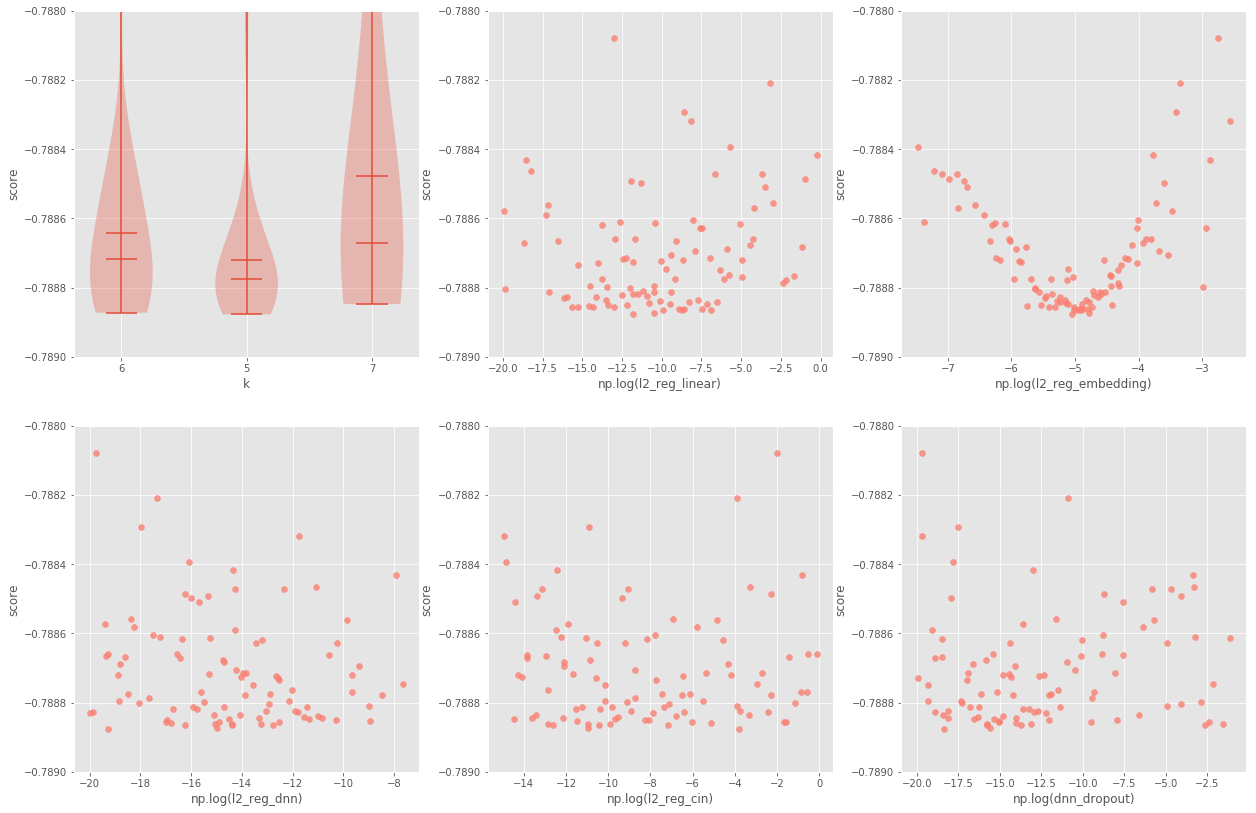

In [14]:
tuning.log.plot(score_interval=[-0.789, -0.788])

In [15]:
seed = np.random.randint(2**32)
print(seed)

3973270008


##  3973270008

In [16]:
######
log.to_csv(f'/data/{seed}.csv', index=False)
#####

In [11]:
! ls ../tmp/xdeepfm

3973270008.csv	4293006264.csv	4293006264predict.npy  4293006264stacking1.npy


In [9]:
######
seed = 3973270008
log = pd.read_csv(f'../tmp/xdeepfm/{seed}.csv')
#####

# Try some new

# stacking

In [ ]:
batch_size = 512
epochs = 400
nflod = 40
nmodel = 1

# model params
model_tuning_param = log.sort_values('score').head(nmodel).reset_index(drop=True).to_dict()

model_fix_param = {'vocabulary': ecd.get_vocabulary(),
                   'loss': 'binary_crossentropy',
                   'metrics': ['AUC'], 
                   'optimizer': 'Adam',
                   'dnn_activation': 'gelu', 
                   'cin_activation': 'linear',
                   'dnn_use_bn': False, 
                   'num_deep_layer': 2, 
                   'num_neuron': 256, 
                   'num_cin_layer': 2,
                   'num_cin': 64}

# callbacks
clr = CyclicLR(
    base_lr=0.1**(5),
    max_lr = 0.1**(4), 
    step_size= int(4.0*(x_train_arr.shape[0]*((nflod-1)/nflod)) / batch_size),
    mode='triangular2',
    gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=5,
                                      mode='max',
                                      restore_best_weights=True)

# fit
fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 1,
    'callbacks':[es, clr]
}

pred_lst = []
score_lst = []
pred_arr_lst = []

for i in range(nmodel):
    model_params = deepcopy(model_fix_param)
    for param_name in model_tuning_param.keys():
        if param_name not in ['score', 'update', 'usetime', 'index']:
            model_params[param_name] = model_tuning_param[param_name][i]
            
    # cv
    model = xdeepfm(**model_params)
    cv = CV(model, nflod)
    
    score, pred_arr = cv.fit(x=mkinput(x_train_arr, feature_col),
                             y=y_train, 
                             metrics_func=roc_auc_score,
                             split_method=StratifiedKFold,
                             fit_params=fit_param,
                             eval_param={'batch_size':batch_size},
                             use_proba=False, 
                             verbose=True,
                             fit_use_valid=True,
                             output_oof_pred=True)
    
    pred = cv.predict(x=mkinput(x_test_arr, feature_col), pred_param={'batch_size': batch_size})
    
    pred_lst.append(pred)
    score_lst.append(score)
    pred_arr_lst.append(pred_arr)
    
    print('score: ', score)
    del model, cv
    tf.keras.backend.clear_session()

Train on 585000 samples, validate on 15000 samples
Epoch 1/400
585000/585000 [==============================] - 53s 91us/sample - loss: 0.5903 - AUC: 0.5208 - val_loss: 0.4725 - val_AUC: 0.7274
Epoch 2/400
585000/585000 [==============================] - 45s 77us/sample - loss: 0.4362 - AUC: 0.7462 - val_loss: 0.4148 - val_AUC: 0.7687
Epoch 3/400
585000/585000 [==============================] - 45s 77us/sample - loss: 0.4065 - AUC: 0.7830 - val_loss: 0.4095 - val_AUC: 0.7785
Epoch 4/400
585000/585000 [==============================] - 46s 78us/sample - loss: 0.4022 - AUC: 0.7899 - val_loss: 0.4084 - val_AUC: 0.7805
Epoch 5/400
585000/585000 [==============================] - 46s 78us/sample - loss: 0.4000 - AUC: 0.7922 - val_loss: 0.4071 - val_AUC: 0.7814
Epoch 6/400
585000/585000 [==============================] - 46s 78us/sample - loss: 0.3981 - AUC: 0.7939 - val_loss: 0.4065 - val_AUC: 0.7811
Epoch 7/400
585000/585000 [==============================] - 46s 78us/sample - loss: 0.3965

In [18]:
score_lst

[0.7889641070088029]